## **DCGAN**

In [ ]:
from glob import glob
from PIL import Image
from IPython import display
import tensorflow.keras as kr
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import imageio
import os

In [ ]:
BATCH_SIZE = 128
LATENT_DIM = 100
SAMPLE_INTERVAL = 200
EPOCHS = 10000

**Utility Functions**

In [ ]:
def generate_gif(gif_name='mnist_gan.gif', pattern='image*.png'):
    with imageio.get_writer(gif_name, mode='I') as writer:
        filenames = glob(pattern)
        filenames = sorted(filenames)
        last = -1
        for i,filename in enumerate(filenames):
            frame = 2*(i**0.5)
            if round(frame) > round(last):
                last = frame
            else:
                continue
            image = imageio.imread(filename)
            writer.append_data(image)

        image = imageio.imread(filename)
        writer.append_data(image)

    # this is a hack to display the gif inside the notebook
    os.system('cp {} {}.png'.format(gif_name, gif_name))

In [ ]:
def sample_images(generator, epoch, save=True, name='mnist'):
    """ Sample images from generator, plot them and save as png"""

    noise = np.random.normal(size=(5 * 5, LATENT_DIM))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5     # Rescale images 0-1

    fig, axs = plt.subplots(5, 5)
    c = 0
    for i in range(5):
        for j in range(5):
            axs[i,j].imshow(gen_imgs[c, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            c += 1

    if save:
        fig.savefig("{}_{}.png".format(name, epoch))
        plt.close()
    else:
        plt.show()

**Starting with MNIST**

In [ ]:
(X, _), (_, _) = kr.datasets.mnist.load_data()

X = X.reshape(X.shape[0], 28, 28, 1).astype('float32')
X = (X - 127.5) / 127.5 # Normalize the images to [-1, 1]

11490434/11490434 [==============================] - 0s 0us/step


**The Generator Model**

In [ ]:
def build_generator(output_shape=(28, 28, 1)):
    model = kr.Sequential(name='generator')

    model.add(kr.layers.Dense(256, input_shape=(LATENT_DIM, )))
    model.add(kr.layers.LeakyReLU(alpha=0.2))
    model.add(kr.layers.BatchNormalization(momentum=0.8))

    model.add(kr.layers.Dense(512))
    model.add(kr.layers.LeakyReLU(alpha=0.2))
    model.add(kr.layers.BatchNormalization(momentum=0.8))

    model.add(kr.layers.Dense(1024))
    model.add(kr.layers.LeakyReLU(alpha=0.2))
    model.add(kr.layers.BatchNormalization(momentum=0.8))

    model.add(kr.layers.Dense(np.prod(output_shape), activation='tanh'))
    model.add(kr.layers.Reshape(output_shape))

    return model


generator = build_generator()
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               25856     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                         

**The Discriminator model**

In [ ]:
def build_discriminator(input_shape=(28, 28, 1)):
    model = kr.Sequential(name='discriminator')

    model.add(kr.layers.Flatten(input_shape=input_shape))
    model.add(kr.layers.Dense(512))
    model.add(kr.layers.LeakyReLU(alpha=0.2))

    model.add(kr.layers.Dense(256))
    model.add(kr.layers.LeakyReLU(alpha=0.2))

    model.add(kr.layers.Dense(1, activation='sigmoid'))

    return model


discriminator = build_discriminator()
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               401920    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 257       
                                                                 
Total params: 533,505
Trainable params: 533,505
Non-t

In [ ]:
optimizer = kr.optimizers.Adam(0.0002, 0.5)

discriminator.compile(loss='binary_crossentropy', optimizer=optimizer,  metrics=['acc'])
discriminator.trainable = False    # For GAN we will only train the generator

z = kr.Input(shape=(LATENT_DIM,))
valid = discriminator(generator(z))

model = kr.Model(z, valid)
model.compile(loss='binary_crossentropy', optimizer=optimizer)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 generator (Sequential)      (None, 28, 28, 1)         1493520   
                                                                 
 discriminator (Sequential)  (None, 1)                 533505    
                                                                 
Total params: 2,027,025
Trainable params: 1,489,936
Non-trainable params: 537,089
_________________________________________________________________


1/1 [==============================] - 0s 89ms/step


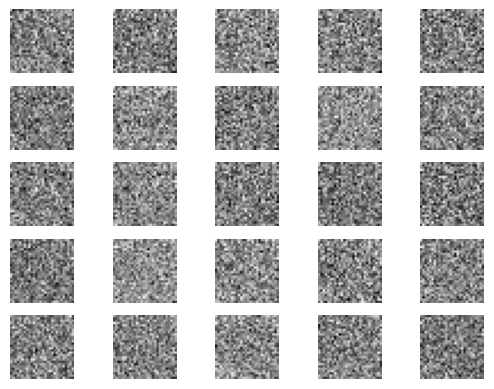

In [ ]:
sample_images(generator, None, save=False)

**DC-GAN with Fashion MNIST**

In [ ]:
(X, _), (_, _) = kr.datasets.fashion_mnist.load_data()

X = X.reshape(X.shape[0], 28, 28, 1).astype('float32')
X = (X - 127.5) / 127.5 # Normalize the images to [-1, 1]

4422102/4422102 [==============================] - 0s 0us/step


**The Generator Model**

In [ ]:
def generator_model():
    model = kr.Sequential()

    model.add(kr.layers.Dense(7 * 7 * 128, activation="relu", input_shape=(LATENT_DIM,)))
    model.add(kr.layers.Reshape((7, 7, 128)))

    model.add(kr.layers.UpSampling2D())
    model.add(kr.layers.Conv2D(128, (3, 3), padding='same'))
    model.add(kr.layers.BatchNormalization(momentum=0.8))
    model.add(kr.layers.ReLU())

    model.add(kr.layers.UpSampling2D())
    model.add(kr.layers.Conv2D(64, (3, 3), padding='same'))
    model.add(kr.layers.BatchNormalization(momentum=0.8))
    model.add(kr.layers.ReLU())

    model.add(kr.layers.Conv2D(1, (3, 3), padding='same', activation='tanh'))

    return model


generator = generator_model()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 6272)              633472    
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       147584    
                                                                 
 batch_normalization_3 (Batc  (None, 14, 14, 128)      512       
 hNormalization)                                                 
                                                                 
 re_lu (ReLU)                (None, 14, 14, 128)      

**The Discriminator model**

In [ ]:
def discriminator_model():
    model = kr.Sequential()

    model.add(kr.layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
    model.add(kr.layers.LeakyReLU(alpha=0.2))
    model.add(kr.layers.Dropout(0.25))

    model.add(kr.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    # model.add(kr.layers.ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(kr.layers.BatchNormalization(momentum=0.8))
    model.add(kr.layers.LeakyReLU(alpha=0.2))
    model.add(kr.layers.Dropout(0.25))

    model.add(kr.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(kr.layers.BatchNormalization(momentum=0.8))
    model.add(kr.layers.LeakyReLU(alpha=0.2))
    model.add(kr.layers.Dropout(0.25))

    model.add(kr.layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(kr.layers.BatchNormalization(momentum=0.8))
    model.add(kr.layers.LeakyReLU(alpha=0.2))
    model.add(kr.layers.Dropout(0.25))

    model.add(kr.layers.Flatten())
    model.add(kr.layers.Dense(1, activation='sigmoid'))

    return model


discriminator = discriminator_model()
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 14, 14, 32)        320       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 14, 14, 32)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 batch_normalization_5 (Batc  (None, 7, 7, 64)         256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                      

**Compile our DC-GAN Model**

In [ ]:
optimizer = kr.optimizers.Adam(0.0002, 0.5)

discriminator.compile(loss='binary_crossentropy', optimizer=optimizer,  metrics=['acc'])
discriminator.trainable = False    # For GAN we will only train the generator

z = kr.Input(shape=(LATENT_DIM,))
valid = discriminator(generator(z))

model = kr.Model(z, valid)
model.compile(loss='binary_crossentropy', optimizer=optimizer)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_2 (Sequential)   (None, 28, 28, 1)         856193    
                                                                 
 sequential_3 (Sequential)   (None, 1)                 390657    
                                                                 
Total params: 1,246,850
Trainable params: 855,809
Non-trainable params: 391,041
_________________________________________________________________


1/1 [==============================] - 0s 145ms/step


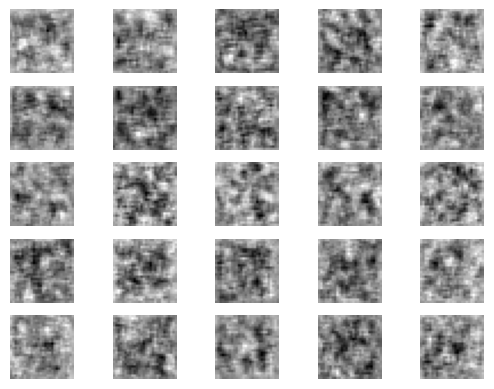

In [ ]:
sample_images(generator, None, save=False, name='../working/fmnist')